In [34]:
#Import libraries
import os
os.chdir("/home/robbe/ionbot/")
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
from pathlib import Path
from pyteomics import mass as pymass
import OxiAnalysis as OA
import importlib
importlib.reload(OA)
import warnings; warnings.simplefilter('ignore')
from statistics import median

# PXD022545

In [35]:
PXD022545 = pd.read_csv("/home/robbe/ionbot/ionbot_0.9.5/PXD022545/new_quatn/QuantifiedPeptides.tsv", sep="\t")
PXD022545.drop(list(PXD022545.filter(regex = 'Detection Type')), axis = 1, inplace = True)
PXD022545 = PXD022545[~PXD022545["Protein Groups"].str.contains("sp|", na=False, regex=False)]

In [36]:
cols = [col for col in PXD022545.columns if "Intensity" in col]

In [37]:
OA.quantile_transform(PXD022545, cols)

,Sequence,Base Sequence,Protein Groups,Gene Names,Organism,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_CTRL_01_20200717061234,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_CTRL_02_20200717083719,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_CTRL_03_20200717110239,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O2_01,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O2_02,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O2_03,Unnamed: 17
0,AAAAAAAAAVSRnan,AAAAAAAAAVSR,ZFP91_HUMAN,NaN,NaN,3.747275,3.603899,NaN,NaN,NaN,NaN,NaN
1,AAAAAAAGDSDSWDADAFSVEDPVRK12|[5]Carbamyl[S],AAAAAAAGDSDSWDADAFSVEDPVRK,EIF3J_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AAAAAAALQAKnan,AAAAAAALQAK,RL4_HUMAN,NaN,NaN,6.370403,6.033333,6.732039,6.238762,5.956871,6.602602,NaN
3,AAAAADGPPAADGEDGQDPHSK4|semi_tryptic,AAAAADGPPAADGEDGQDPHSK,TXND5_HUMAN,NaN,NaN,2.850465,4.563751,3.758288,4.082936,3.420915,2.959491,NaN
4,AAAAADLANRnan,AAAAADLANR,NaN,NaN,NaN,3.880936,4.493210,4.140690,4.466974,4.256666,4.205373,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
34439,YYTVFDRDNNRnan,YYTVFDRDNNR,CATD_HUMAN,NaN,NaN,4.211243,3.893778,NaN,5.983841,6.133266,6.016473,NaN
34440,YYTVFDRnan,YYTVFDR,CATD_HUMAN,NaN,NaN,6.513738,6.685640,6.650354,6.753311,6.599146,6.675384,NaN
34441,YYVTIIDAPGHRDFIKnan,YYVTIIDAPGHRDFIK,NaN,NaN,NaN,5.264041,5.515966,5.915349,4.702836,2.636120,5.719961,NaN
34442,YYVTIIDAPGHRnan,YYVTIIDAPGHR,NaN,NaN,NaN,6.745842,6.829568,7.083108,6.600170,6.325088,7.113736,NaN


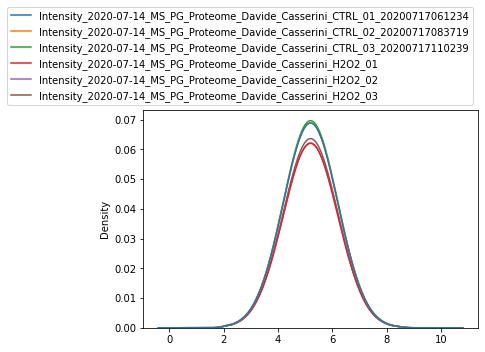

In [38]:
ax = sns.kdeplot(data=PXD022545[cols])
sns.move_legend(ax, "lower right", bbox_to_anchor=(1, 1))

In [39]:
PXD022545[cols] = PXD022545[cols].transform(lambda x: x/x.sum())

In [40]:
db = pymass.Unimod()
def modifications(seq):
    if seq.endswith("nan"):
        return None
    else:
        pattern = re.compile(pattern=r"\[(\d+)\]")
        matches = re.findall(pattern, seq)
        if matches != None:
            for i in matches:
                return [i for i in matches]
                
def get_delta_mass(seq):
    
    if seq.endswith("nan"):
        return 0
    else:
        pattern = re.compile(pattern=r"\[(\d+)\]")
        matches = re.findall(pattern, seq)
        if matches != None:
            delta_mass = 0
            for i in matches:
                    for p in range(len(db.mods)):
                        if db.mods[p]['record_id'] == float(i):
                
                            mm = db.mods[p]['mono_mass']
                            # mm = db.mods[p]['delta_mono_mass']
                            delta_mass += mm
                            delta_mass = round(delta_mass, 2)
            return delta_mass
        else:
            return 0
                    

In [41]:
PXD022545["Modifications"] = PXD022545["Sequence"].apply(modifications)
PXD022545["Delta_mass"] = PXD022545["Sequence"].apply(get_delta_mass)
No_zero = PXD022545[PXD022545["Delta_mass"] != 0]

In [42]:
g = No_zero.groupby("Delta_mass").sum().reset_index()

In [43]:
g['medianCtrl']=g.apply(lambda x:median([x[c] for c in g.columns if "CTRL" in c]),axis=1)
g["medianH2O2"]=g.apply(lambda x:median([x[c] for c in g.columns if "H2O2" in c]), axis=1)

g["Difference"] = (g["medianH2O2"] - g["medianCtrl"])

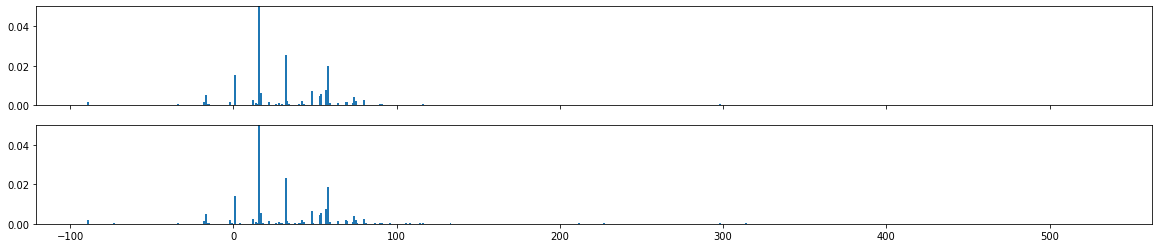

In [44]:
fig, (ax1,ax2) = plt.subplots(ncols = 1, nrows=2, sharey = True, sharex=True)

ax1.bar(x=g.Delta_mass, height=g.medianH2O2, width=1.2)
ax2.bar(x=g.Delta_mass, height=g.medianCtrl, width=1.2)

fig.set_size_inches(20,4)
plt.ylim(0,0.05)
plt.show()

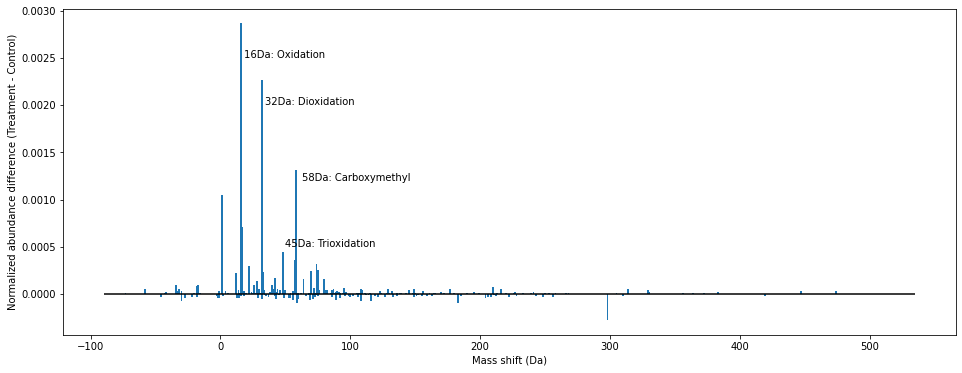

In [46]:
fig, ax = plt.subplots()
# ax = sns.barplot(data=gfiltered, x="Delta_mass", y="Quotient")
ax.bar(x=g.Delta_mass, height=g.Difference, width=1.4)
fig.set_size_inches(16,6)
plt.hlines(y=0,xmin=-90, xmax=535, color="k")
plt.xlabel("Mass shift (Da)")
plt.ylabel("Normalized abundance difference (Treatment - Control)")
plt.text(x= 18, y= 0.0025, s= "16Da: Oxidation")
plt.text(x=34, y= 0.002, s="32Da: Dioxidation")
plt.text(x=50, y= 0.0005, s="45Da: Trioxidation")
plt.text(x=63, y = 0.0012, s="58Da: Carboxymethyl")
plt.show()

In [13]:
sorted = g.sort_values(by="Difference", axis=0, ascending=False)

In [14]:
sorted.head(10)

,Delta_mass,Gene Names,Organism,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_CTRL_01_20200717061234,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_CTRL_02_20200717083719,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_CTRL_03_20200717110239,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O2_01,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O2_02,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O2_03,Unnamed: 17,medianCtrl,medianH2O2,Difference
54,15.99,0.0,0.0,0.140753,0.140746,0.143008,0.143729,0.142638,0.143621,0.0,0.140753,0.143621,0.002868
83,31.98,0.0,0.0,0.023277,0.023302,0.022390,0.026670,0.025545,0.025347,0.0,0.023277,0.025545,0.002268
148,58.01,0.0,0.0,0.018920,0.018737,0.018237,0.018651,0.020392,0.020055,0.0,0.018737,0.020055,0.001318
35,0.98,0.0,0.0,0.014351,0.014275,0.014037,0.015320,0.015530,0.014979,0.0,0.014275,0.015320,0.001045
56,17.03,0.0,0.0,0.005516,0.006077,0.005585,0.006290,0.006427,0.005896,0.0,0.005585,0.006290,0.000705
125,47.98,0.0,0.0,0.006850,0.006572,0.006684,0.007219,0.007122,0.006576,0.0,0.006684,0.007122,0.000439
146,57.02,0.0,0.0,0.007343,0.007307,0.006914,0.007237,0.007971,0.007663,0.0,0.007307,0.007663,0.000356
181,74.00,0.0,0.0,0.004083,0.003906,0.003831,0.004216,0.004248,0.004217,0.0,0.003906,0.004217,0.000311
64,21.98,0.0,0.0,0.001242,0.001430,0.001214,0.001542,0.001538,0.001406,0.0,0.001242,0.001538,0.000296
184,75.01,0.0,0.0,0.002068,0.001923,0.001928,0.002182,0.002236,0.002129,0.0,0.001928,0.002182,0.000254


15.99: oxidations

31.98: Dioxidation

58.01: carboxymethyl

47.98: trioxidation

74.00: oxidation + carboxymethyl

21.98: sodium adduct

In [15]:
sorted.tail(10)

,Delta_mass,Gene Names,Organism,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_CTRL_01_20200717061234,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_CTRL_02_20200717083719,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_CTRL_03_20200717110239,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O2_01,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O2_02,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O2_03,Unnamed: 17,medianCtrl,medianH2O2,Difference
109,43.01,0.0,0.0,0.000779,0.000650,0.000809,0.000721,0.000919,0.000633,0.0,0.000779,0.000721,-0.000058
170,68.90,0.0,0.0,0.001857,0.001929,0.001795,0.002014,0.001795,0.001784,0.0,0.001857,0.001795,-0.000062
217,89.01,0.0,0.0,0.000116,0.000116,0.000111,0.000040,0.000098,0.000048,0.0,0.000116,0.000048,-0.000068
139,55.92,0.0,0.0,0.000168,0.000148,0.000150,0.000126,0.000082,0.000078,0.0,0.000150,0.000082,-0.000068
292,116.01,0.0,0.0,0.000465,0.000470,0.000449,0.000389,0.000355,0.000450,0.0,0.000465,0.000389,-0.000076
270,108.00,0.0,0.0,0.000149,0.000188,0.000174,0.000070,0.000097,0.000102,0.0,0.000174,0.000097,-0.000077
12,-29.99,0.0,0.0,0.000114,0.000118,0.000102,0.000035,0.000071,0.000033,0.0,0.000114,0.000035,-0.000079
413,183.04,0.0,0.0,0.000095,0.000094,0.000094,0.000000,0.000000,0.000000,0.0,0.000094,0.000000,-0.000094
151,59.02,0.0,0.0,0.001149,0.001227,0.001120,0.001050,0.001201,0.001025,0.0,0.001149,0.001050,-0.000099
488,298.15,0.0,0.0,0.000641,0.000663,0.000549,0.000363,0.000406,0.000305,0.0,0.000641,0.000363,-0.000278


298.15: biotin adduct


In [16]:
PXD022545 = PXD022545.explode("Modifications")

In [17]:
Carboxymethyl = PXD022545[PXD022545["Modifications"] == "6"]

In [18]:
Carboxymethyl["AA"] = Carboxymethyl["Sequence"].apply(lambda x: re.search(r"Carboxymethyl\[(.*)\]", x).group(1))

In [19]:
a = re.search(r"Carboxymethyl\[(.)\]", "AAAIGIDLGTTYSCVGVFQHGK14|[6]Carboxymethyl[C]").group(1)
print(a)

C


In [20]:
Carboxymethyl.sum()

Sequence                                                                       AAAIGIDLGTTYSCVGVFQHGK14|[6]Carboxymethyl[C]AA...
Base Sequence                                                                  AAAIGIDLGTTYSCVGVFQHGKAACNLLQRAALANLCIGDVITAID...
Gene Names                                                                                                                   0.0
Organism                                                                                                                     0.0
Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_CTRL_01_20200717061234                                             0.023337
Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_CTRL_02_20200717083719                                             0.022954
Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_CTRL_03_20200717110239                                             0.022427
Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O2_01                                     

In [21]:
Carboxymethyllysine = Carboxymethyl[Carboxymethyl["AA"] == "K"]

In [22]:
Carboxymethyllysine.sum()

Sequence                                                                       AGAVEKGVPLYR6|[6]Carboxymethyl[K]AITIAGVPQSVTE...
Base Sequence                                                                  AGAVEKGVPLYRAITIAGVPQSVTECVKALGQNPTNAEVLKVLGNP...
Gene Names                                                                                                                   0.0
Organism                                                                                                                     0.0
Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_CTRL_01_20200717061234                                             0.001127
Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_CTRL_02_20200717083719                                             0.001072
Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_CTRL_03_20200717110239                                             0.001062
Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O2_01                                     

In [23]:
median([0.001303, 0.001203, 0.001115]) / median([0.023169, 0.025058, 0.024546])

0.04901002199951113

In [24]:
def contains_l(string):
    if "L" in string:
        return True
    else:
        return False

In [25]:
Carboxymethyl["Contains_L"] = Carboxymethyl["Base Sequence"].apply(contains_l)

In [26]:
Carboxymethyl["Contains_L"].value_counts()

True     482
False    170
Name: Contains_L, dtype: int64

In [27]:
PXD022545[PXD022545["Delta_mass"] == 298.15]

,Sequence,Base Sequence,Protein Groups,Gene Names,Organism,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_CTRL_01_20200717061234,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_CTRL_02_20200717083719,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_CTRL_03_20200717110239,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O2_01,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O2_02,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O2_03,Unnamed: 17,Modifications,Delta_mass
2512,ASGPPVSELITK0|[1314]biotinAcrolein298[N-TERM],ASGPPVSELITK,NaN,NaN,NaN,NaN,0.000030,NaN,NaN,0.000034,NaN,NaN,1314,298.15
2636,ATAENEFVVLK0|[1314]biotinAcrolein298[N-TERM],ATAENEFVVLK,NaN,NaN,NaN,0.000039,NaN,NaN,NaN,0.000033,NaN,NaN,1314,298.15
3099,AWGPGLEGGVVGK0|[1314]biotinAcrolein298[N-TERM],AWGPGLEGGVVGK,FLNA_HUMAN,NaN,NaN,0.000036,0.000042,0.000035,NaN,NaN,0.000034,NaN,1314,298.15
4593,DIPGLTDTTVPR0|[1314]biotinAcrolein298[N-TERM],DIPGLTDTTVPR,RS6_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1314,298.15
5269,DPAECPQAQLTDNANQLLLVSSR5|[1314]biotinAcrolein2...,DPAECPQAQLTDNANQLLLVSSR,NaN,NaN,NaN,NaN,0.000015,NaN,NaN,NaN,NaN,NaN,1314,298.15
5673,DSPSVWAAVPGK0|[1314]biotinAcrolein298[N-TERM],DSPSVWAAVPGK,NaN,NaN,NaN,0.000038,NaN,0.000035,NaN,NaN,NaN,NaN,1314,298.15
7427,EILDAFDK0|[1314]biotinAcrolein298[N-TERM],EILDAFDK,SAP_HUMAN,NaN,NaN,NaN,NaN,NaN,0.000050,0.000049,0.000046,NaN,1314,298.15
8944,ETNLDSLPLVDTHSK0|[1314]biotinAcrolein298[N-TERM],ETNLDSLPLVDTHSK,VIME_HUMAN,NaN,NaN,0.000038,0.000036,0.000037,0.000037,0.000037,0.000036,NaN,1314,298.15
14134,IDYIAGLDSR0|[1314]biotinAcrolein298[N-TERM],IDYIAGLDSR,APT_HUMAN,NaN,NaN,0.000034,0.000033,0.000029,NaN,NaN,NaN,NaN,1314,298.15
15471,IQLVEEELDR0|[1314]biotinAcrolein298[N-TERM],IQLVEEELDR,NaN,NaN,NaN,NaN,0.000040,NaN,0.000045,0.000043,0.000039,NaN,1314,298.15


# PXD012477

In [97]:
PXD012477 = pd.read_csv("/home/robbe/ionbot/ionbot_0.9.5/PXD012477/flashlfq_results/QuantifiedPeptides.tsv", sep="\t")
PXD012477.drop(list(PXD012477.filter(regex = 'Detection Type')), axis = 1, inplace = True)
PXD012477.head()

,Sequence,Base Sequence,Protein Groups,Gene Names,Organism,Intensity_1DLC012615QE_RRAG_014B_rep4,Intensity_1DLC121914QE_RRAG_029_rep4,Intensity_1DLC122214QE_RRAG_040_rep4,Intensity_1DLC071515QE_RRAG_058B_rep2,Intensity_1DLC121514QE_RRAG_019_rep2,...,Intensity_1DLC122214QE_RRAG_036_rep1,Intensity_1DLC060615QE_RRAG_037B_rep3,Intensity_1DLC121514QE_RRAG_022_rep3,Intensity_1DLC122914QE_RRAG_055_rep3,Intensity_1DLC012615QE_RRAG_006B_rep3,Intensity_1DLC061715QE_RRAG_038B_rep4,Intensity_1DLC121414QE_RRAG_012_rep2,Intensity_1DLC051815QE_RRAG_018B_rep2,Intensity_1DLC012615QE_RRAG_007B_rep1,Unnamed: 983
0,AAAAAAAAAAAAAAAASAGGKx|[1927]Delta:H(4)C(5)O(1...,AAAAAAAAAAAAAAAASAGGK,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.0,0.000000e+00,...,0.000000e+00,0.0,0.0,7.056849e+05,0.000000,0.0,1.097085e+06,0.0,108828.848060,NaN
1,AAAAAAAAAKNGSSGKnan,AAAAAAAAAKNGSSGK,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.0,0.000000e+00,...,0.000000e+00,0.0,0.0,0.000000e+00,0.000000,0.0,0.000000e+00,0.0,0.000000,NaN
2,AAAAAAAAGAFAGRR14|[1918]Carbonyl[R],AAAAAAAAGAFAGRR,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.0,0.000000e+00,...,0.000000e+00,0.0,0.0,0.000000e+00,0.000000,0.0,0.000000e+00,0.0,0.000000,NaN
3,AAAAAAAAGAFAGRR7|[1918]Carbonyl[A],AAAAAAAAGAFAGRR,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.0,0.000000e+00,...,0.000000e+00,0.0,0.0,0.000000e+00,0.000000,0.0,0.000000e+00,0.0,0.000000,NaN
4,AAAAAAAAQMHAKx|[205]Delta:H(6)C(6)O(1)[K],AAAAAAAAQMHAK,NaN,NaN,NaN,308918.957796,211139.976308,459861.238281,0.0,1.235488e+06,...,1.319586e+06,0.0,0.0,1.874100e+06,191749.419922,0.0,0.000000e+00,0.0,349322.769137,NaN


In [98]:
cols = [col for col in PXD012477.columns if "Intensity" in col]

In [99]:
OA.quantile_transform(PXD012477, cols)

,Sequence,Base Sequence,Protein Groups,Gene Names,Organism,Intensity_1DLC012615QE_RRAG_014B_rep4,Intensity_1DLC121914QE_RRAG_029_rep4,Intensity_1DLC122214QE_RRAG_040_rep4,Intensity_1DLC071515QE_RRAG_058B_rep2,Intensity_1DLC121514QE_RRAG_019_rep2,...,Intensity_1DLC122214QE_RRAG_036_rep1,Intensity_1DLC060615QE_RRAG_037B_rep3,Intensity_1DLC121514QE_RRAG_022_rep3,Intensity_1DLC122914QE_RRAG_055_rep3,Intensity_1DLC012615QE_RRAG_006B_rep3,Intensity_1DLC061715QE_RRAG_038B_rep4,Intensity_1DLC121414QE_RRAG_012_rep2,Intensity_1DLC051815QE_RRAG_018B_rep2,Intensity_1DLC012615QE_RRAG_007B_rep1,Unnamed: 983
0,AAAAAAAAAAAAAAAASAGGKx|[1927]Delta:H(4)C(5)O(1...,AAAAAAAAAAAAAAAASAGGK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,5.450977,NaN,NaN,5.444851,NaN,5.288095,NaN
1,AAAAAAAAAKNGSSGKnan,AAAAAAAAAKNGSSGK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AAAAAAAAGAFAGRR14|[1918]Carbonyl[R],AAAAAAAAGAFAGRR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAAAAAAAGAFAGRR7|[1918]Carbonyl[A],AAAAAAAAGAFAGRR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAAAAAAAQMHAKx|[205]Delta:H(6)C(6)O(1)[K],AAAAAAAAQMHAK,NaN,NaN,NaN,5.944721,5.402606,5.979366,NaN,6.076624,...,6.145115,NaN,NaN,6.079100,5.925638,NaN,NaN,NaN,5.872692,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102383,YYYVCQYCPAGNWANR8|[4]carbamidomethyl[C]|5|[100...,YYYVCQYCPAGNWANR,CRIS3_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102384,YYYVCQYCPAGNWANR8|[4]carbamidomethyl[C]|5|[131...,YYYVCQYCPAGNWANR,CRIS3_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102385,YYYVCQYCPAGNWANR8|[4]carbamidomethyl[C]|5|[6]C...,YYYVCQYCPAGNWANR,CRIS3_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102386,YYYVCQYCPAGNWANR8|[4]carbamidomethyl[C]|5|[999...,YYYVCQYCPAGNWANR,CRIS3_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


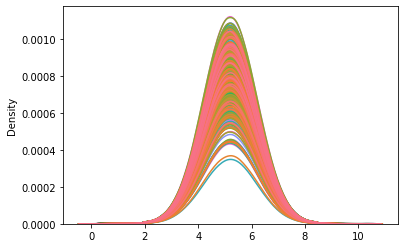

In [100]:
ax = sns.kdeplot(data=PXD012477[cols], legend=False)

In [101]:
PXD012477[cols] = PXD012477[cols].transform(lambda x: x/x.sum())

In [102]:
PXD012477["Modifications"] = PXD012477["Sequence"].apply(modifications)
PXD012477["Delta_mass"] = PXD012477["Sequence"].apply(get_delta_mass)

In [103]:
No_zero = PXD012477[PXD012477["Delta_mass"] != 0]

In [104]:
g = No_zero.groupby("Delta_mass").sum().reset_index()

In [105]:
dict = {}
patientIDlist = []
patientIDBlist = []
for i in range(1,66):
    patientID = "_"+str(i).zfill(3)+"_"
    patientIDB = "_"+str(i).zfill(3)+"B_"
    patientIDlist.append(patientID)
    patientIDBlist.append(patientIDB)
for patient in patientIDlist:
    selected = g[[col for col in g if patient in col]]
    selected["Delta_mass"] = g["Delta_mass"]
    dict[patient] = selected
for patientB in patientIDBlist:
    selectedB = g[[col for col in g if patientB in col]]
    selected["Delta_mass"] = g["Delta_mass"]
    dict[patientB] = selectedB

In [106]:
for i in dict:
    df = dict[i]
    df["median"] = df.median(axis=1)

In [107]:
data = pd.DataFrame()
data["Delta_mass"] = g["Delta_mass"]
for patient in dict:
    data[patient] = dict[patient]["median"]

In [108]:
data.dropna(axis=1, inplace=True)

In [109]:
Healthydf = pd.DataFrame()
NonHealthydf = pd.DataFrame()
Healthydf["Delta_mass"] = data["Delta_mass"]
NonHealthydf["Delta_mass"] = data["Delta_mass"]
Healthy = [1,3,4,5,6,11,13,14,19,21,23,24,25,28,29,32,33,34,36,37,40,41,42,47,52,54,56,57,60,61,65]
NonHealthy = [2,7,9,10,12,15,17,18,20,22,26,27,30,31,35,38,39,43,44,45,46,48,49,50,51,53,55,58,59,62,63,64,8,16]
patienlist = []
patienBlist = []
for i in Healthy:
    patien = "_"+str(i).zfill(3)+"_"
    patienlist.append(patien)
    patienB = "_"+str(i).zfill(3)+"B_"
    patienBlist.append(patienB)

for i in patienlist:
    if i in data.columns:
        Healthydf[i] = data[i]
for i in patienBlist:
    if i in data.columns:
        Healthydf[i] = data[i]


patielist = []
patieBlist = []
data["Delta_mass"] = g["Delta_mass"]
for i in NonHealthy:
    patie = "_"+str(i).zfill(3)+"_"
    patielist.append(patie)
    patieB = "_"+str(i).zfill(3)+"B_"
    patieBlist.append(patieB)

for i in patielist:
    if i in data.columns:
        NonHealthydf[i] = data[i]
for i in patieBlist:
    if i in data.columns:
        NonHealthydf[i] = data[i]

In [110]:
Healthydf.set_index("Delta_mass",inplace=True)
Healthy = Healthydf.median(axis=1).to_frame().reset_index()

NonHealthydf.set_index("Delta_mass", inplace=True)
NonHealthy = NonHealthydf.median(axis=1).to_frame().reset_index()

In [111]:
mergedata = data = pd.merge(Healthy, NonHealthy, how="outer", on=["Delta_mass", "Delta_mass"], suffixes=["H","NH"])

In [112]:
data["Difference"] = data["0NH"] - data["0H"]

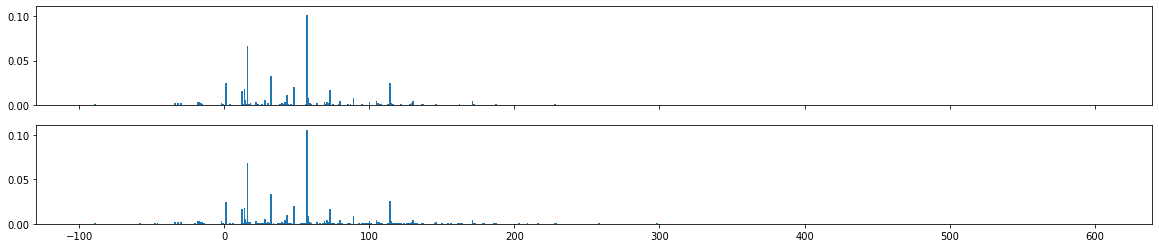

In [113]:
fig, (ax1,ax2) = plt.subplots(ncols = 1, nrows=2, sharey = True, sharex=True)
# sns.barplot(ax = axes[0], data=gfiltered, x="Delta_mass", y="meanH2O2")
# sns.barplot(ax = axes[1], data=gfiltered, x="Delta_mass", y="meanCtrl")
ax1.bar(x=data.Delta_mass, height=data["0NH"], width=1.2)
ax2.bar(x=data.Delta_mass, height=data["0H"], width=1.2)

fig.set_size_inches(20,4)
plt.show()

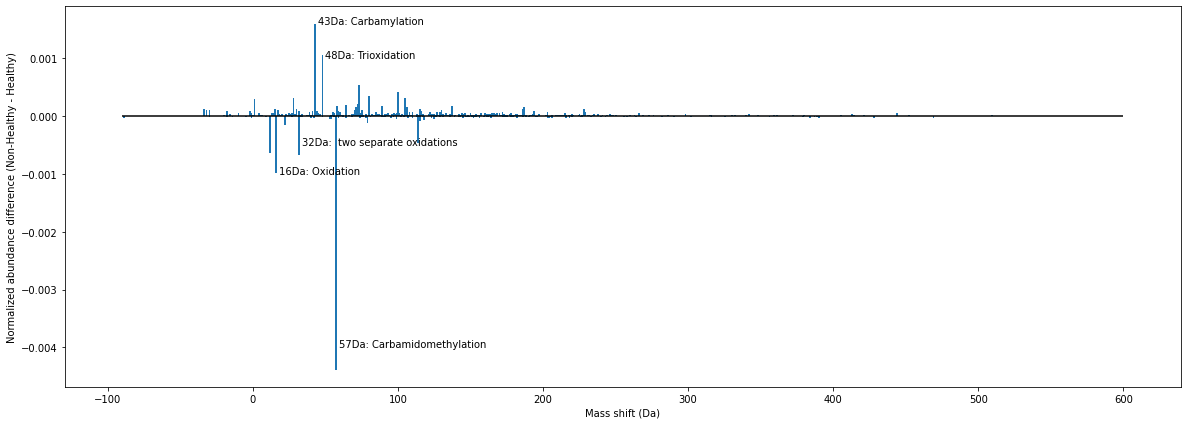

In [114]:
fig, ax = plt.subplots()
# ax = sns.barplot(data=gfiltered, x="Delta_mass", y="Quotient")
ax.bar(x=data.Delta_mass, height=data.Difference, width=1.2)
fig.set_size_inches(20,7)
plt.hlines(y=0,xmin=-90, xmax=600, color="k")
plt.ylabel("Normalized abundance difference (Non-Healthy - Healthy)")
plt.xlabel("Mass shift (Da)")
plt.text(x=45, y=0.0016, s="43Da: Carbamylation")
plt.text(x=50, y = 0.001, s="48Da: Trioxidation")
plt.text(x=18, y= -0.001, s = "16Da: Oxidation")
plt.text(x=34, y = -0.0005, s="32Da:  two separate oxidations")
plt.text(x=59, y=-0.004, s="57Da: Carbamidomethylation")
# plt.ylim(0,7000)
# plt.xticks([0,10,20,30,40,50,60,70,80,90,100])
plt.show()

In [115]:
sorted = data.sort_values(by="Difference", axis=0, ascending=False)

In [116]:
sorted.head(10)

,Delta_mass,0H,0NH,Difference
141,43.01,0.010133,0.011734,0.001601
162,47.98,0.019844,0.020895,0.001050
255,73.01,0.016089,0.016621,0.000532
365,100.03,0.002613,0.003037,0.000424
285,79.97,0.003970,0.004310,0.000340
393,105.00,0.004130,0.004451,0.000321
97,27.99,0.005547,0.005855,0.000308
49,0.98,0.024272,0.024561,0.000289
250,72.02,0.001958,0.002168,0.000210
219,63.97,0.001818,0.002019,0.000201


43.01: Carbamyl

47.98: trioxidation

73.01: carbamidomethyl + oxidation

100.03: carbamyl + carbamidomethyl

79.97: phospho

105.00: carbamidomethyl + trioxidation

27.99: formylation

72.02: carboxyethyl

63.97: oxidation + trioxidation


In [117]:
sorted.tail(10)

,Delta_mass,0H,0NH,Difference
452,118.07,0.000417,0.000358,-0.000059
437,115.03,0.002848,0.002769,-0.000079
436,115.02,0.001248,0.001167,-0.000081
280,79.00,0.001313,0.001198,-0.000115
84,21.98,0.003629,0.003467,-0.000162
434,114.04,0.025597,0.025129,-0.000469
59,12.00,0.016774,0.016138,-0.000636
111,31.99,0.033128,0.032458,-0.000670
73,15.99,0.067760,0.066783,-0.000977
192,57.02,0.105627,0.101243,-0.004384


15.99: oxidation

31.99: two oxidations

114.04: Ubiquitination

21.98: sodium adduct

In [118]:
PXD012477[PXD012477["Delta_mass"] == 79.00]

,Sequence,Base Sequence,Protein Groups,Gene Names,Organism,Intensity_1DLC012615QE_RRAG_014B_rep4,Intensity_1DLC121914QE_RRAG_029_rep4,Intensity_1DLC122214QE_RRAG_040_rep4,Intensity_1DLC071515QE_RRAG_058B_rep2,Intensity_1DLC121514QE_RRAG_019_rep2,...,Intensity_1DLC121514QE_RRAG_022_rep3,Intensity_1DLC122914QE_RRAG_055_rep3,Intensity_1DLC012615QE_RRAG_006B_rep3,Intensity_1DLC061715QE_RRAG_038B_rep4,Intensity_1DLC121414QE_RRAG_012_rep2,Intensity_1DLC051815QE_RRAG_018B_rep2,Intensity_1DLC012615QE_RRAG_007B_rep1,Unnamed: 983,Modifications,Delta_mass
888,AATGECTATVGK6|[4]carbamidomethyl[C]|5|[30]Cati...,AATGECTATVGK,KNG1_HUMAN,NaN,NaN,0.000047,NaN,NaN,0.000058,0.000050,...,NaN,NaN,NaN,NaN,NaN,0.000067,NaN,NaN,"[4, 30]",79.0
5236,APDTGNAHCADCGAADPDWASYKLGIFICLNCCGVHRNFPDISR9|...,APDTGNAHCADCGAADPDWASYKLGIFICLNCCGVHRNFPDISR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[4, 1913]",79.0
5901,AQLVPLPPSTYVEFTVSGTDCVAK21|[4]carbamidomethyl[...,AQLVPLPPSTYVEFTVSGTDCVAK,FETUA_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[4, 30]",79.0
7276,ATLVCLISDFYPGAVTVAWK5|[4]carbamidomethyl[C]|9|...,ATLVCLISDFYPGAVTVAWK,;IGL1_HUMAN;IGLC3_HUMAN,NaN,NaN,0.000034,0.000045,0.000045,0.000055,NaN,...,NaN,NaN,NaN,0.000058,NaN,NaN,NaN,NaN,"[4, 30]",79.0
7384,ATLVCLVSDFNPGAVTVAWK5|[4]carbamidomethyl[C]|9|...,ATLVCLVSDFNPGAVTVAWK,IGLC7_HUMAN,NaN,NaN,0.000029,NaN,NaN,NaN,0.000034,...,0.000052,NaN,0.000044,NaN,0.000055,NaN,0.000047,NaN,"[4, 30]",79.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99528,YFCQLYTDPPQESYTTITVLVPPR3|[4]carbamidomethyl[C...,YFCQLYTDPPQESYTTITVLVPPR,CADM1_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[4, 30]",79.0
99882,YGPPCPSCPAPEFLGGPSVFLFPPK5|[4]carbamidomethyl[...,YGPPCPSCPAPEFLGGPSVFLFPPK,IGHG4_HUMAN,NaN,NaN,0.000038,0.000039,0.000041,NaN,0.000039,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[4, 30]",79.0
100166,YICENQDSISSK3|[4]carbamidomethyl[C]|4|[30]Cati...,YICENQDSISSK,ALBU_HUMAN,NaN,NaN,0.000053,NaN,NaN,0.000055,NaN,...,NaN,0.000065,0.000045,NaN,0.000069,0.000066,NaN,NaN,"[4, 30]",79.0
100192,YICENQDSISSK3|[4]carbamidomethyl[C]|7|[30]Cati...,YICENQDSISSK,ALBU_HUMAN,NaN,NaN,0.000057,NaN,NaN,NaN,0.000054,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000045,NaN,"[4, 30]",79.0


# PXD016278

In [119]:
PXD016278 = pd.read_csv("/home/robbe/ionbot/ionbot_0.9.5/PXD016278/flashlfq/QuantifiedPeptides.tsv", sep="\t")
PXD016278.drop(list(PXD016278.filter(regex = 'Detection Type')), axis = 1, inplace = True)
PXD016278.head()

,Sequence,Base Sequence,Protein Groups,Gene Names,Organism,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction01,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction02R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction03_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction04_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction05_R2,...,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction16,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction17,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction18,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction19,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction20,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction21,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction22,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction23,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction24,Unnamed: 101
0,AAAAAAAAAAAAAAAGAGAGAKnan,AAAAAAAAAAAAAAAGAGAGAK,S12A2_HUMAN,NaN,NaN,0.000000e+00,0.000000,0.000000e+00,0.0,0.0,...,0.000000e+00,6.157306e+05,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,NaN
1,AAAAAAAAAKnan,AAAAAAAAAK,PHX2B_HUMAN,NaN,NaN,0.000000e+00,0.000000,0.000000e+00,0.0,0.0,...,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,NaN
2,AAAAAAAAAVSRR12|[981]glucosone[R],AAAAAAAAAVSRR,NaN,NaN,NaN,3.159841e+06,194429.501953,0.000000e+00,0.0,0.0,...,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,NaN
3,AAAAAAAAGAFAGRR14|[1918]Carbonyl[R],AAAAAAAAGAFAGRR,NaN,NaN,NaN,0.000000e+00,0.000000,0.000000e+00,0.0,0.0,...,1.407283e+06,1.882486e+06,0.0,0.0,0.0,0.0,0.0,2.078671e+07,0.0,NaN
4,AAAAAAAAGAFAGRR15|[1918]Carbonyl[R],AAAAAAAAGAFAGRR,NaN,NaN,NaN,0.000000e+00,0.000000,4.562765e+06,8516465.0,0.0,...,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,NaN


In [120]:
cols = [col for col in PXD016278.columns if "Intensity" in col]

In [121]:
OA.quantile_transform(PXD016278, cols)

,Sequence,Base Sequence,Protein Groups,Gene Names,Organism,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction01,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction02R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction03_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction04_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction05_R2,...,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction16,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction17,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction18,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction19,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction20,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction21,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction22,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction23,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction24,Unnamed: 101
0,AAAAAAAAAAAAAAAGAGAGAKnan,AAAAAAAAAAAAAAAGAGAGAK,S12A2_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4.451812,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAAAAAAAAKnan,AAAAAAAAAK,PHX2B_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AAAAAAAAAVSRR12|[981]glucosone[R],AAAAAAAAAVSRR,NaN,NaN,NaN,5.525634,4.076628,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAAAAAAAGAFAGRR14|[1918]Carbonyl[R],AAAAAAAAGAFAGRR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.619585,5.205255,NaN,NaN,NaN,NaN,NaN,5.998512,NaN,NaN
4,AAAAAAAAGAFAGRR15|[1918]Carbonyl[R],AAAAAAAAGAFAGRR,NaN,NaN,NaN,NaN,NaN,5.586813,5.883837,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108603,YYYAVYDMVVR8|[35]oxidation[M],YYYAVYDMVVR,LAMB1_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108604,YYYAVYDMVVRnan,YYYAVYDMVVR,LAMB1_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.268374,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108605,YYYDGKDYIEFNK6|[4]Carbamidomethyl[K],YYYDGKDYIEFNK,ZA2G_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.469734,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108606,YYYDGKDYIEFNKnan,YYYDGKDYIEFNK,ZA2G_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


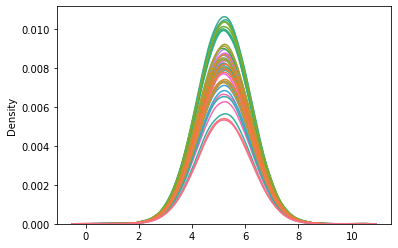

In [122]:
ax = sns.kdeplot(data=PXD016278[cols], legend=False)

In [123]:
PXD016278[cols] = PXD016278[cols].transform(lambda x: x/x.sum())

In [124]:
PXD016278["Modifications"] = PXD016278["Sequence"].apply(modifications)
PXD016278["Delta_mass"] = PXD016278["Sequence"].apply(get_delta_mass)

In [125]:
No_zero = PXD016278[PXD016278["Delta_mass"] != 0]

In [126]:
g = No_zero.groupby("Delta_mass").sum().reset_index()

In [127]:
g['medianCtrl']=g.apply(lambda x:median([x[c] for c in g.columns if "ctrl2" in c]),axis=1)
g["medianAD"]=g.apply(lambda x:median([x[c] for c in g.columns if "AD2" in c]), axis=1)
g["Difference"] = g["medianAD"] - g["medianCtrl"]

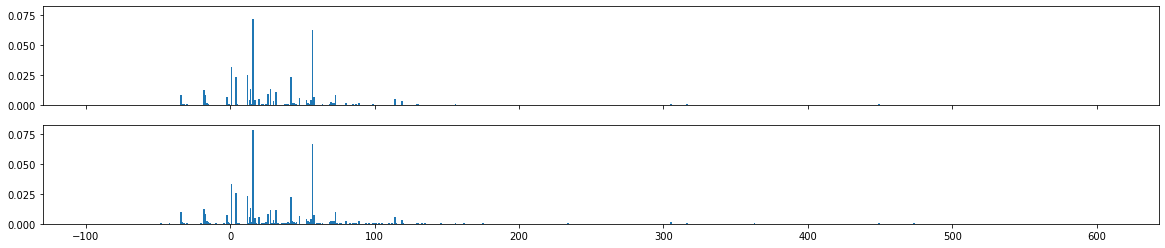

In [128]:
fig, (ax1,ax2) = plt.subplots(ncols = 1, nrows=2, sharey = True, sharex=True)
# sns.barplot(ax = axes[0], data=gfiltered, x="Delta_mass", y="meanH2O2")
# sns.barplot(ax = axes[1], data=gfiltered, x="Delta_mass", y="meanCtrl")
ax1.bar(x=g.Delta_mass, height=g.medianAD, width=1.2)
ax2.bar(x=g.Delta_mass, height=g.medianCtrl, width=1.2)

fig.set_size_inches(20,4)
plt.show()

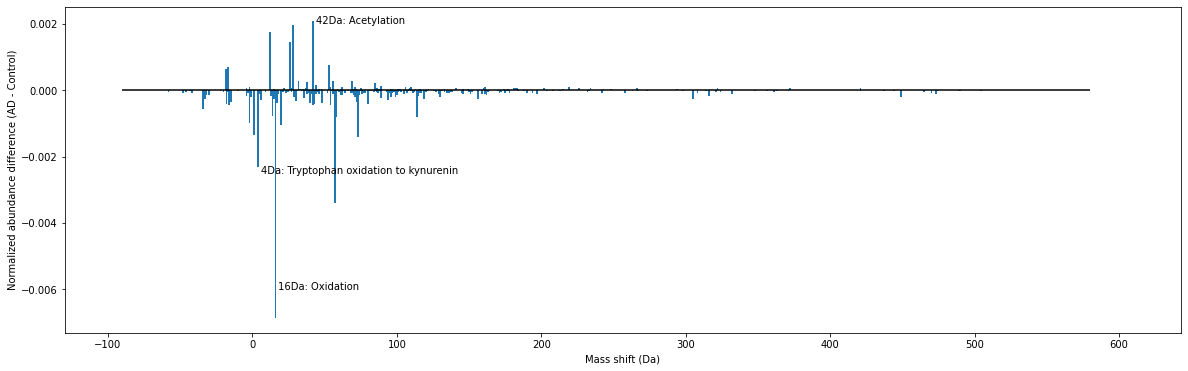

In [129]:
fig, ax = plt.subplots()
# ax = sns.barplot(data=gfiltered, x="Delta_mass", y="Quotient")
ax.bar(x=g.Delta_mass, height=g.Difference, width=1.2)
fig.set_size_inches(20,6)
plt.hlines(y=0,xmin=-90, xmax=580, color="k")
plt.text(x=44, y=0.002, s="42Da: Acetylation")
plt.text(x=18, y=-0.006, s="16Da: Oxidation")
plt.text(x=6, y=-0.0025, s="4Da: Tryptophan oxidation to kynurenin")
plt.xlabel("Mass shift (Da)")
plt.ylabel("Normalized abundance difference (AD - Control)")

plt.show()

In [130]:
sorted = g.sort_values(by="Difference", axis=0, ascending=False)

In [131]:
sorted.head(10)

,Delta_mass,Gene Names,Organism,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction01,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction02R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction03_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction04_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction05_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction06_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction07_R2,...,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction19,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction20,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction21,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction22,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction23,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction24,Unnamed: 101,medianCtrl,medianAD,Difference
141,42.01,0.0,0.0,0.007370,0.008765,0.007511,0.005096,0.004382,0.005221,0.003786,...,0.006572,0.006137,0.006534,0.007733,0.008670,0.007571,0.0,0.006553,0.008626,0.002073
95,27.99,0.0,0.0,0.033603,0.013852,0.012364,0.012936,0.011455,0.010872,0.013268,...,0.012084,0.010869,0.010930,0.009754,0.011617,0.013183,0.0,0.011344,0.013315,0.001971
56,12.00,0.0,0.0,0.015924,0.021332,0.021555,0.020097,0.017586,0.016036,0.018098,...,0.021256,0.022647,0.021731,0.022256,0.024102,0.023424,0.0,0.023094,0.024854,0.001760
89,26.02,0.0,0.0,0.005677,0.005024,0.006447,0.005757,0.005655,0.005203,0.006507,...,0.008355,0.009617,0.008135,0.008295,0.007897,0.008851,0.0,0.007970,0.009412,0.001442
143,42.05,0.0,0.0,0.015594,0.016198,0.014871,0.013312,0.014402,0.014425,0.017977,...,0.030695,0.031372,0.026278,0.015699,0.018468,0.027082,0.0,0.022400,0.023606,0.001206
96,28.03,0.0,0.0,0.003943,0.005924,0.005262,0.004529,0.003921,0.004555,0.004565,...,0.007768,0.006208,0.005366,0.006732,0.005179,0.007242,0.0,0.006015,0.006937,0.000921
175,52.91,0.0,0.0,0.003564,0.003949,0.005711,0.004321,0.003652,0.002424,0.002965,...,0.003353,0.004927,0.004041,0.002698,0.002409,0.003548,0.0,0.003961,0.004710,0.000749
24,-17.03,0.0,0.0,0.007577,0.007695,0.008513,0.009488,0.008950,0.007312,0.007871,...,0.007640,0.008079,0.011366,0.012035,0.009464,0.008263,0.0,0.007802,0.008496,0.000694
21,-18.01,0.0,0.0,0.014306,0.011095,0.012689,0.011587,0.013051,0.010326,0.012080,...,0.011639,0.010634,0.013197,0.014248,0.012801,0.012668,0.0,0.012036,0.012684,0.000648
110,31.98,0.0,0.0,0.008411,0.008668,0.009536,0.008725,0.008367,0.009180,0.007778,...,0.007035,0.007221,0.005537,0.007245,0.006543,0.008374,0.0,0.006985,0.007278,0.000293


42.01: Acetylation

26.02: Acetaldehyde +26

42.05: Trimethyl

28.03: di-Methyl

52.91: replacement of 3 protons by iron

-17.03: loss of ammonia

-18.01: dehydration

31.98: dioxidation


In [132]:
sorted.tail(10)

,Delta_mass,Gene Names,Organism,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction01,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction02R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction03_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction04_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction05_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction06_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction07_R2,...,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction19,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction20,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction21,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction22,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction23,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction24,Unnamed: 101,medianCtrl,medianAD,Difference
63,13.98,0.0,0.0,0.004026,0.004444,0.004665,0.006501,0.005039,0.005345,0.007567,...,0.005450,0.005725,0.004835,0.006386,0.007321,0.006447,0.0,0.005408,0.004617,-0.000791
435,114.04,0.0,0.0,0.005144,0.004451,0.005124,0.005907,0.004290,0.004639,0.004556,...,0.003743,0.005593,0.006606,0.006225,0.007477,0.006677,0.0,0.005959,0.005144,-0.000815
199,58.04,0.0,0.0,0.002525,0.003200,0.002520,0.002524,0.002448,0.002686,0.003116,...,0.005521,0.004537,0.003712,0.002883,0.002223,0.004910,0.0,0.004024,0.003204,-0.000820
38,-2.02,0.0,0.0,0.007154,0.005834,0.006544,0.006665,0.006633,0.005438,0.007468,...,0.007140,0.008041,0.007599,0.009173,0.008712,0.009313,0.0,0.007690,0.006688,-0.001001
77,19.98,0.0,0.0,0.004470,0.004105,0.004904,0.004872,0.004621,0.004783,0.003902,...,0.006027,0.005313,0.005275,0.005036,0.004643,0.006787,0.0,0.005862,0.004828,-0.001035
47,0.98,0.0,0.0,0.034534,0.027780,0.032154,0.032574,0.032512,0.029511,0.033724,...,0.033062,0.034334,0.033841,0.037423,0.036384,0.034798,0.0,0.033335,0.031993,-0.001342
260,73.01,0.0,0.0,0.008411,0.008377,0.010017,0.011205,0.010779,0.010758,0.009711,...,0.007375,0.008527,0.008025,0.009703,0.009479,0.009107,0.0,0.009998,0.008602,-0.001396
49,3.99,0.0,0.0,0.023835,0.027127,0.020688,0.024693,0.025617,0.025095,0.026472,...,0.031375,0.023688,0.022531,0.021816,0.021003,0.029528,0.0,0.026014,0.023685,-0.002329
196,57.02,0.0,0.0,0.059997,0.057086,0.061625,0.063300,0.058627,0.055040,0.057000,...,0.060589,0.063278,0.063452,0.063019,0.063359,0.061068,0.0,0.066597,0.063189,-0.003408
71,15.99,0.0,0.0,0.080065,0.078325,0.084784,0.088163,0.091764,0.094128,0.085233,...,0.078875,0.073170,0.074924,0.078801,0.078890,0.077970,0.0,0.078660,0.071794,-0.006867


15.99: oxidation

3.99: tryptophan oxidation to kynurenin

73.01: oxidation + carbamidomethyl

19.98: tryptophan oxidation to hydroxykynurenin + oxidation

-2.02: didehydro

58.04: 	Reduced acrolein addition +58

114.04: ubiquitin

13.98: carbonyl


# PXD014381

In [133]:
PXD014381 = pd.read_csv("/home/robbe/ionbot/ionbot_0.9.5/PXD014381/mzml_files/QuantifiedPeptides.tsv", sep="\t")
PXD014381.drop(list(PXD014381.filter(regex = 'Detection Type|Unnamed')), axis = 1, inplace = True)
PXD014381 = PXD014381[~PXD014381["Protein Groups"].str.contains("sp|", na=False, regex=False)]

In [134]:
cols = [col for col in PXD014381.columns if "Intensity" in col]

In [135]:
OA.quantile_transform(PXD014381, cols)

,Sequence,Base Sequence,Protein Groups,Gene Names,Organism,Intensity_QX01983,Intensity_QX01981_160316090220,Intensity_QX01867,Intensity_QX01870,Intensity_QX01873,Intensity_QX01862,Intensity_QX01865,Intensity_QX01868,Intensity_QX01984,Intensity_QX01874,Intensity_QX01860,Intensity_QX01863,Intensity_QX01866,Intensity_QX01869,Intensity_QX01872
0,AAAAAAAAAAAAAAAAGATCLER20|[935]Atto495Maleimid...,AAAAAAAAAAAAAAAAGATCLER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAAAAAAAAAGAAGGR0|[1]Acetyl[N-TERM],AAAAAAAAAAGAAGGR,PABP2_HUMAN,NaN,NaN,NaN,NaN,6.121298,5.834774,5.523748,5.969850,6.008275,5.814900,5.310131,6.111347,5.875306,6.006802,6.001351,6.031433,4.350659
2,AAAAAAAAAVSRnan,AAAAAAAAAVSR,ZFP91_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.248033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAAAAAAAVPSAGPAGPAPTSAAGR0|[9999530]Methyl_2H(...,AAAAAAAAVPSAGPAGPAPTSAAGR,IRS2_HUMAN,NaN,NaN,4.591761,4.455139,4.479478,4.110906,4.311641,4.294662,4.883361,4.690469,4.427945,4.772457,3.814937,3.621315,4.745856,4.482498,4.514642
4,AAAAAAAAVPSAGPAGPAPTSAAGRnan,AAAAAAAAVPSAGPAGPAPTSAAGR,IRS2_HUMAN,NaN,NaN,5.164943,5.006685,5.240198,5.295028,5.566057,5.232198,5.265588,5.261213,4.935918,5.523181,5.284992,5.187497,5.100125,5.137829,5.381597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39163,YYVTIIDAPGHR2|[4]Carbamidomethyl[Y],YYVTIIDAPGHR,NaN,NaN,NaN,5.489817,6.574731,6.515439,6.427139,3.666679,4.921354,5.515669,5.434582,5.857403,NaN,5.734494,6.082803,5.559171,6.234073,6.162652
39164,YYVTIIDAPGHRDFIK16|[320]Nethylmaleimide+water[K],YYVTIIDAPGHRDFIK,NaN,NaN,NaN,3.133248,6.807918,6.676688,4.847939,5.458636,6.341033,4.844949,6.651371,4.514573,6.710468,3.859167,6.509451,6.445864,4.484046,6.530901
39165,YYVTIIDAPGHRnan,YYVTIIDAPGHR,NaN,NaN,NaN,7.770552,8.082394,7.970133,7.948876,7.602078,7.994151,8.040760,8.062211,8.117252,8.129415,7.925919,8.089237,7.991904,8.046757,8.075467
39166,YYVTIIDAPNHR10|Gly->Asn[G],YYVTIIDAPNHR,NaN,NaN,NaN,4.016578,NaN,6.442717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


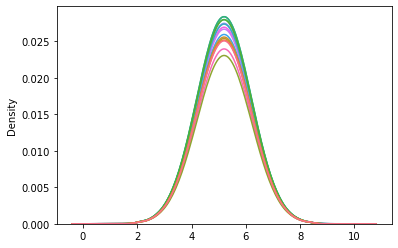

In [136]:
ax = sns.kdeplot(data=PXD014381[cols], legend=False)

In [137]:
PXD014381[cols] = PXD014381[cols].transform(lambda x: x/x.sum())

In [138]:
PXD014381["Modifications"] = PXD014381["Sequence"].apply(modifications)
PXD014381["Delta_mass"] = PXD014381["Sequence"].apply(get_delta_mass)

In [139]:
No_zero = PXD014381[PXD014381["Delta_mass"] != 0]

In [140]:
g = No_zero.groupby("Delta_mass").sum().reset_index()

In [141]:
g['medianCtrl']=g.apply(lambda x:median([x[c] for c in ['Intensity_QX01983', 'Intensity_QX01981_160316090220', 'Intensity_QX01867', 'Intensity_QX01870', 'Intensity_QX01873']]),axis=1)
g["medianRA"]=g.apply(lambda x:median([x[c] for c in ['Intensity_QX01860','Intensity_QX01863','Intensity_QX01866','Intensity_QX01869','Intensity_QX01872']]), axis=1)
g["medianDiamide"] = g.apply(lambda x:median([x[c] for c in ['Intensity_QX01862','Intensity_QX01865','Intensity_QX01868','Intensity_QX01984','Intensity_QX01874']]), axis=1)
g["Difference"] = (g["medianRA"] - g["medianCtrl"])
g["DiaDifference"] = (g["medianDiamide"] - g["medianCtrl"])
g["DiaRADifference"] = (g["medianDiamide"] - g["medianRA"])

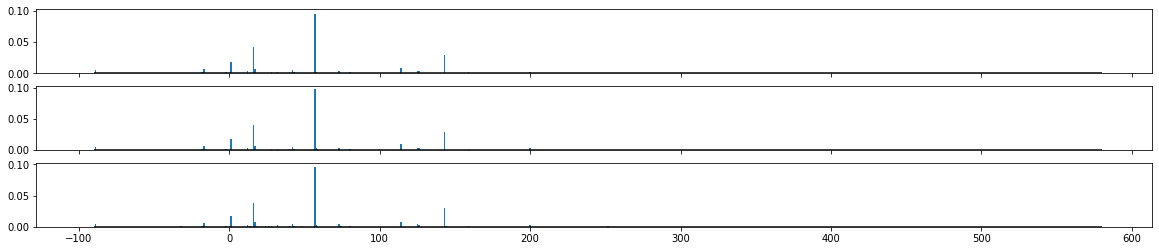

In [142]:
fig, (ax1,ax2,ax3) = plt.subplots(ncols = 1, nrows=3, sharey = True, sharex=True)
ax1.bar(x=g.Delta_mass, height=g.medianRA, width=1.2)
ax3.bar(x=g.Delta_mass, height=g.medianCtrl, width=1.2)
ax2.bar(x=g.Delta_mass, height=g.medianDiamide, width=1.2)
ax1.hlines(y=0,xmin=-90, xmax=580, color="k")
ax2.hlines(y=0,xmin=-90, xmax=580, color="k")
ax3.hlines(y=0,xmin=-90, xmax=580, color="k")

fig.set_size_inches(20,4)
# plt.ylim(0,4000)
plt.show()

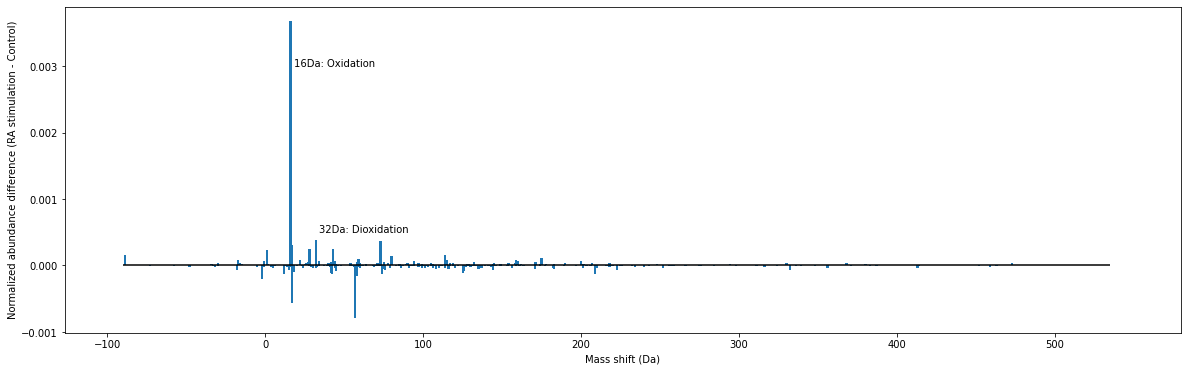

In [143]:
fig, ax = plt.subplots()
# ax = sns.barplot(data=gfiltered, x="Delta_mass", y="Quotient")
ax.bar(x=g.Delta_mass, height=g.Difference, width=1.4)
fig.set_size_inches(20,6)
plt.hlines(y=0,xmin=-90, xmax=535, color="k")
plt.text(x= 18, y = 0.003, s="16Da: Oxidation")
plt.text(x = 34, y = 0.0005, s="32Da: Dioxidation")
plt.xlabel("Mass shift (Da)")
plt.ylabel("Normalized abundance difference (RA stimulation - Control)")

plt.show()

In [144]:
sorted = g.sort_values(by="Difference", axis=0, ascending=False)

In [145]:
sorted.head(10)

,Delta_mass,Gene Names,Organism,Intensity_QX01983,Intensity_QX01981_160316090220,Intensity_QX01867,Intensity_QX01870,Intensity_QX01873,Intensity_QX01862,Intensity_QX01865,...,Intensity_QX01863,Intensity_QX01866,Intensity_QX01869,Intensity_QX01872,medianCtrl,medianRA,medianDiamide,Difference,DiaDifference,DiaRADifference
51,15.99,0.0,0.0,0.038194,0.039707,0.038898,0.037436,0.042623,0.040671,0.039365,...,0.042568,0.054811,0.037448,0.041205,0.038898,0.042568,0.039849,0.003670,0.000950,-0.002720
84,31.98,0.0,0.0,0.001253,0.001376,0.001206,0.001217,0.001234,0.001495,0.001287,...,0.001622,0.002499,0.001135,0.001227,0.001234,0.001622,0.001287,0.000389,0.000053,-0.000336
175,73.01,0.0,0.0,0.003197,0.003908,0.004064,0.003712,0.003662,0.003678,0.003929,...,0.004081,0.005044,0.003596,0.003863,0.003712,0.004081,0.003828,0.000370,0.000117,-0.000253
52,16.97,0.0,0.0,0.001282,0.001373,0.001430,0.001626,0.001665,0.001920,0.001662,...,0.001711,0.002299,0.001534,0.001732,0.001430,0.001732,0.001662,0.000302,0.000233,-0.000070
72,27.99,0.0,0.0,0.001218,0.001326,0.001387,0.001407,0.001263,0.000963,0.000877,...,0.001573,0.002161,0.001294,0.001377,0.001326,0.001573,0.000963,0.000246,-0.000363,-0.000610
108,43.01,0.0,0.0,0.001127,0.000935,0.001216,0.001121,0.001269,0.001036,0.001046,...,0.001831,0.002057,0.001360,0.001371,0.001127,0.001371,0.001046,0.000245,-0.000081,-0.000326
34,0.98,0.0,0.0,0.017350,0.017709,0.018599,0.018925,0.017334,0.018038,0.017533,...,0.018089,0.017802,0.017948,0.017060,0.017709,0.017948,0.017452,0.000239,-0.000257,-0.000496
278,114.04,0.0,0.0,0.007623,0.008041,0.008855,0.008530,0.007783,0.008240,0.008935,...,0.008204,0.007494,0.008362,0.008514,0.008041,0.008204,0.008935,0.000162,0.000893,0.000731
1,-89.03,0.0,0.0,0.004579,0.004380,0.004552,0.004785,0.004324,0.004837,0.004682,...,0.004988,0.004880,0.004641,0.004187,0.004552,0.004713,0.004682,0.000161,0.000130,-0.000031
197,79.97,0.0,0.0,0.001376,0.001258,0.001356,0.001613,0.001133,0.001491,0.001446,...,0.001515,0.001500,0.001339,0.001157,0.001356,0.001500,0.001433,0.000145,0.000077,-0.000067


15.99: oxidation

31.98: Dioxidation

73.01: oxidation + carbamido

16.97: oxidation + deamidation

43.01: carbamyl

79.97: Phospho



In [146]:
sorted.tail(10)

,Delta_mass,Gene Names,Organism,Intensity_QX01983,Intensity_QX01981_160316090220,Intensity_QX01867,Intensity_QX01870,Intensity_QX01873,Intensity_QX01862,Intensity_QX01865,...,Intensity_QX01863,Intensity_QX01866,Intensity_QX01869,Intensity_QX01872,medianCtrl,medianRA,medianDiamide,Difference,DiaDifference,DiaRADifference
309,125.05,0.0,0.0,0.004021,0.004101,0.004234,0.004179,0.003772,0.004095,0.003988,...,0.004043,0.003972,0.004038,0.003986,0.004101,0.003986,0.003956,-0.000115,-0.000146,-0.000030
140,58.04,0.0,0.0,0.001165,0.001347,0.000997,0.001027,0.000778,0.000696,0.001181,...,0.001152,0.000726,0.001252,0.000907,0.001027,0.000907,0.000967,-0.000120,-0.000060,0.000060
107,42.05,0.0,0.0,0.000426,0.000430,0.000418,0.000414,0.000200,0.000270,0.000318,...,0.000321,0.000292,0.000297,0.000151,0.000418,0.000297,0.000270,-0.000121,-0.000147,-0.000026
40,12.00,0.0,0.0,0.003368,0.003089,0.003366,0.003425,0.003102,0.002941,0.003254,...,0.003037,0.002865,0.003444,0.003427,0.003366,0.003243,0.003065,-0.000123,-0.000301,-0.000178
179,74.05,0.0,0.0,0.000728,0.000753,0.000529,0.000669,0.000720,0.000565,0.000614,...,0.000595,0.000598,0.000567,0.000476,0.000720,0.000595,0.000565,-0.000125,-0.000155,-0.000030
521,209.02,0.0,0.0,0.000446,0.000292,0.000371,0.000143,0.000533,0.000357,0.000382,...,0.000244,0.000177,0.000229,0.000273,0.000371,0.000244,0.000382,-0.000128,0.000011,0.000139
138,58.00,0.0,0.0,0.002762,0.003013,0.003142,0.002761,0.002951,0.002973,0.002855,...,0.003041,0.002765,0.003178,0.002522,0.002951,0.002795,0.002855,-0.000156,-0.000096,0.000060
30,-2.02,0.0,0.0,0.001964,0.001799,0.001874,0.001155,0.001971,0.001535,0.001850,...,0.001674,0.001575,0.001562,0.001795,0.001874,0.001674,0.001849,-0.000200,-0.000025,0.000175
53,17.03,0.0,0.0,0.008713,0.008923,0.006740,0.007109,0.007849,0.007096,0.007476,...,0.007462,0.007281,0.007736,0.006699,0.007849,0.007289,0.007096,-0.000560,-0.000753,-0.000193
137,57.02,0.0,0.0,0.092757,0.096041,0.096060,0.096460,0.091225,0.092160,0.097752,...,0.095561,0.088779,0.095971,0.095251,0.096041,0.095251,0.097752,-0.000789,0.001711,0.002500


17.03: Ammonium

-2: Didehydro

74.05: carbamido + ammonium

42.05: trimethyl

58.04: trimethyl + oxidation of reduced acrolein adduct





In [147]:
PXD014381[PXD014381["Delta_mass"] == 143.06]

,Sequence,Base Sequence,Protein Groups,Gene Names,Organism,Intensity_QX01983,Intensity_QX01981_160316090220,Intensity_QX01867,Intensity_QX01870,Intensity_QX01873,...,Intensity_QX01868,Intensity_QX01984,Intensity_QX01874,Intensity_QX01860,Intensity_QX01863,Intensity_QX01866,Intensity_QX01869,Intensity_QX01872,Modifications,Delta_mass
5,AAAAAAALQAKSDEK11|[320]Nethylmaleimide+water[K],AAAAAAALQAKSDEK,RL4_HUMAN,NaN,NaN,0.000051,0.000049,0.000052,0.000053,0.000057,...,0.000046,0.000046,0.000047,0.000051,0.000046,0.000048,0.000049,0.000055,[320],143.06
147,AAATQPDAKDTPDEPWAFPAR9|[320]Nethylmaleimide+wa...,AAATQPDAKDTPDEPWAFPAR,SND1_HUMAN,NaN,NaN,0.000038,0.000035,0.000037,0.000040,NaN,...,0.000036,0.000035,0.000037,0.000038,0.000038,0.000036,0.000038,NaN,[320],143.06
151,AAAVGTANKSTVEGIQASVK9|[320]Nethylmaleimide+wat...,AAAVGTANKSTVEGIQASVK,VINC_HUMAN,NaN,NaN,0.000031,0.000029,0.000027,0.000030,0.000038,...,0.000026,0.000024,0.000032,0.000030,0.000027,0.000031,0.000025,0.000037,[320],143.06
161,AACNLLQR3|[320]Nethylmaleimide+water[C],AACNLLQR,PFKAP_HUMAN,NaN,NaN,0.000047,0.000043,0.000042,0.000042,0.000046,...,0.000033,0.000034,NaN,0.000044,0.000040,0.000042,0.000042,0.000045,[320],143.06
195,AAEAGGAEEQYGFLTTPTKQLGAQSPGR19|[320]Nethylmale...,AAEAGGAEEQYGFLTTPTKQLGAQSPGR,MAP1B_HUMAN,NaN,NaN,0.000025,NaN,0.000032,0.000032,NaN,...,0.000031,0.000023,NaN,0.000032,0.000029,0.000034,0.000032,NaN,[320],143.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39027,YVDIAIPCNNK8|[320]Nethylmaleimide+water[C],YVDIAIPCNNK,RSSA_HUMAN,NaN,NaN,NaN,0.000042,NaN,0.000042,0.000046,...,0.000039,NaN,0.000045,NaN,NaN,0.000038,NaN,0.000053,[320],143.06
39031,YVECSALTQK4|[320]Nethylmaleimide+water[C],YVECSALTQK,CDC42_HUMAN,NaN,NaN,0.000035,0.000040,0.000044,0.000043,0.000046,...,0.000041,0.000039,0.000045,0.000049,0.000044,0.000047,0.000043,NaN,[320],143.06
39040,YVEPIEDVPCGNIVGLVGVDQFLVK10|[320]Nethylmaleimi...,YVEPIEDVPCGNIVGLVGVDQFLVK,EF2_HUMAN,NaN,NaN,0.000047,0.000047,0.000040,0.000045,0.000048,...,0.000038,0.000046,0.000040,0.000040,0.000041,0.000040,0.000043,0.000044,[320],143.06
39105,YWLCAATGPSIK4|[320]Nethylmaleimide+water[C],YWLCAATGPSIK,RACK1_HUMAN,NaN,NaN,0.000029,0.000040,0.000042,0.000038,0.000045,...,0.000039,0.000041,0.000042,0.000041,0.000040,0.000040,0.000039,0.000046,[320],143.06


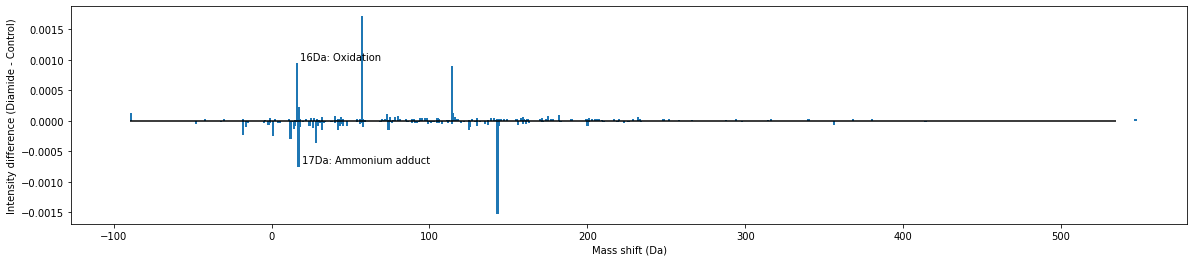

In [148]:
fig, ax = plt.subplots()
# ax = sns.barplot(data=gfiltered, x="Delta_mass", y="Quotient")
ax.bar(x=g.Delta_mass, height=g.DiaDifference, width=1.4)
fig.set_size_inches(20,4)
plt.hlines(y=0,xmin=-90, xmax=535, color="k")
plt.xlabel("Mass shift (Da)")
plt.ylabel("Intensity difference (Diamide - Control)")
plt.text(x = 18, y=0.001, s="16Da: Oxidation")
plt.text(x=19, y = -0.0007, s="17Da: Ammonium adduct")
# plt.ylim(200)
# plt.xticks([0,10,20,30,40,50,60,70,80,90,100])

plt.show()

In [149]:
sorted = g.sort_values(by="DiaDifference", axis=0, ascending=False)

In [150]:
sorted.head(10)

,Delta_mass,Gene Names,Organism,Intensity_QX01983,Intensity_QX01981_160316090220,Intensity_QX01867,Intensity_QX01870,Intensity_QX01873,Intensity_QX01862,Intensity_QX01865,...,Intensity_QX01863,Intensity_QX01866,Intensity_QX01869,Intensity_QX01872,medianCtrl,medianRA,medianDiamide,Difference,DiaDifference,DiaRADifference
137,57.02,0.0,0.0,0.092757,0.096041,0.096060,0.096460,0.091225,0.092160,0.097752,...,0.095561,0.088779,0.095971,0.095251,0.096041,0.095251,0.097752,-0.000789,0.001711,0.002500
51,15.99,0.0,0.0,0.038194,0.039707,0.038898,0.037436,0.042623,0.040671,0.039365,...,0.042568,0.054811,0.037448,0.041205,0.038898,0.042568,0.039849,0.003670,0.000950,-0.002720
278,114.04,0.0,0.0,0.007623,0.008041,0.008855,0.008530,0.007783,0.008240,0.008935,...,0.008204,0.007494,0.008362,0.008514,0.008041,0.008204,0.008935,0.000162,0.000893,0.000731
52,16.97,0.0,0.0,0.001282,0.001373,0.001430,0.001626,0.001665,0.001920,0.001662,...,0.001711,0.002299,0.001534,0.001732,0.001430,0.001732,0.001662,0.000302,0.000233,-0.000070
1,-89.03,0.0,0.0,0.004579,0.004380,0.004552,0.004785,0.004324,0.004837,0.004682,...,0.004988,0.004880,0.004641,0.004187,0.004552,0.004713,0.004682,0.000161,0.000130,-0.000031
282,115.06,0.0,0.0,0.000232,0.000213,0.000166,0.000125,0.000116,0.000110,0.000325,...,0.000226,0.000212,0.000224,0.000359,0.000166,0.000224,0.000289,0.000058,0.000123,0.000065
280,115.02,0.0,0.0,0.000112,0.000117,0.000123,0.000147,0.000193,0.000278,0.000295,...,0.000184,0.000188,0.000169,0.000207,0.000123,0.000186,0.000244,0.000062,0.000121,0.000058
175,73.01,0.0,0.0,0.003197,0.003908,0.004064,0.003712,0.003662,0.003678,0.003929,...,0.004081,0.005044,0.003596,0.003863,0.003712,0.004081,0.003828,0.000370,0.000117,-0.000253
281,115.03,0.0,0.0,0.000153,0.000235,0.000242,0.000278,0.000363,0.000281,0.000371,...,0.000353,0.000325,0.000292,0.000338,0.000242,0.000330,0.000352,0.000088,0.000110,0.000021
469,182.07,0.0,0.0,0.000244,0.000209,0.000215,0.000136,0.000208,0.000288,0.000278,...,0.000225,0.000167,0.000133,0.000166,0.000209,0.000167,0.000305,-0.000042,0.000096,0.000138


15.99: Oxidation

16.97: oxidation + deamidation

115.06: oxidation + reduced acrolein

73.01: oxidation + carbamidomethyl



In [151]:
sorted.tail(10)

,Delta_mass,Gene Names,Organism,Intensity_QX01983,Intensity_QX01981_160316090220,Intensity_QX01867,Intensity_QX01870,Intensity_QX01873,Intensity_QX01862,Intensity_QX01865,...,Intensity_QX01863,Intensity_QX01866,Intensity_QX01869,Intensity_QX01872,medianCtrl,medianRA,medianDiamide,Difference,DiaDifference,DiaRADifference
85,31.99,0.0,0.0,0.002314,0.002282,0.002369,0.002363,0.002273,0.002257,0.002170,...,0.002196,0.002307,0.002384,0.002422,0.002314,0.002384,0.002170,0.000070,-0.000144,-0.000214
309,125.05,0.0,0.0,0.004021,0.004101,0.004234,0.004179,0.003772,0.004095,0.003988,...,0.004043,0.003972,0.004038,0.003986,0.004101,0.003986,0.003956,-0.000115,-0.000146,-0.000030
107,42.05,0.0,0.0,0.000426,0.000430,0.000418,0.000414,0.000200,0.000270,0.000318,...,0.000321,0.000292,0.000297,0.000151,0.000418,0.000297,0.000270,-0.000121,-0.000147,-0.000026
179,74.05,0.0,0.0,0.000728,0.000753,0.000529,0.000669,0.000720,0.000565,0.000614,...,0.000595,0.000598,0.000567,0.000476,0.000720,0.000595,0.000565,-0.000125,-0.000155,-0.000030
17,-18.01,0.0,0.0,0.001261,0.001500,0.001437,0.001509,0.001135,0.001167,0.001300,...,0.001295,0.001503,0.001441,0.001348,0.001437,0.001368,0.001211,-0.000070,-0.000226,-0.000156
34,0.98,0.0,0.0,0.017350,0.017709,0.018599,0.018925,0.017334,0.018038,0.017533,...,0.018089,0.017802,0.017948,0.017060,0.017709,0.017948,0.017452,0.000239,-0.000257,-0.000496
40,12.00,0.0,0.0,0.003368,0.003089,0.003366,0.003425,0.003102,0.002941,0.003254,...,0.003037,0.002865,0.003444,0.003427,0.003366,0.003243,0.003065,-0.000123,-0.000301,-0.000178
72,27.99,0.0,0.0,0.001218,0.001326,0.001387,0.001407,0.001263,0.000963,0.000877,...,0.001573,0.002161,0.001294,0.001377,0.001326,0.001573,0.000963,0.000246,-0.000363,-0.000610
53,17.03,0.0,0.0,0.008713,0.008923,0.006740,0.007109,0.007849,0.007096,0.007476,...,0.007462,0.007281,0.007736,0.006699,0.007849,0.007289,0.007096,-0.000560,-0.000753,-0.000193
362,143.06,0.0,0.0,0.028940,0.029675,0.030332,0.030084,0.029879,0.028855,0.028353,...,0.029869,0.029931,0.029794,0.029928,0.029879,0.029869,0.028353,-0.000009,-0.001526,-0.001516


17.03: Ammonium

-18.01	: Dehydrated

74.05: ammonium + carbamidomethyl

42.05: Trimethyl

31.99: two oxidations

## Ageing

In [152]:
Ageing=  pd.read_csv("/home/robbe/ionbot/Ageing_study/Ageing_combined.csv")

In [153]:
Ageing["Modifications"] = Ageing["Sequence"].apply(modifications)
Ageing["Delta_mass"] = Ageing["Sequence"].apply(get_delta_mass)
No_zero = Ageing[Ageing["Delta_mass"] != 0]

In [154]:
g = No_zero.groupby("Delta_mass").sum().reset_index()

In [155]:
g["MedianYoung"] = g.apply(lambda x:median([x[c] for c in g.columns if "VUR" in c]), axis=1)
g["MedianOld"] = g.apply(lambda x: median([x[c] for c in g.columns if "RRAG" in c]), axis=1)
g["Difference"] = (g["MedianOld"] - g["MedianYoung"])

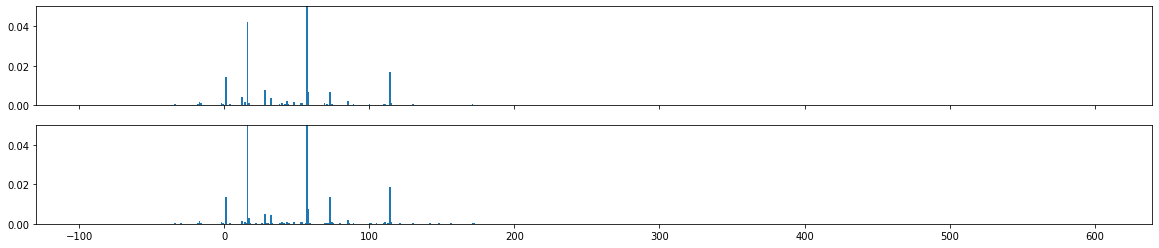

In [156]:
fig, (ax1,ax2) = plt.subplots(ncols = 1, nrows=2, sharey = True, sharex=True)

ax1.bar(x=g.Delta_mass, height=g.MedianOld, width=1.2)
ax2.bar(x=g.Delta_mass, height=g.MedianYoung, width=1.2)

fig.set_size_inches(20,4)
plt.ylim(0,0.05)
plt.show()

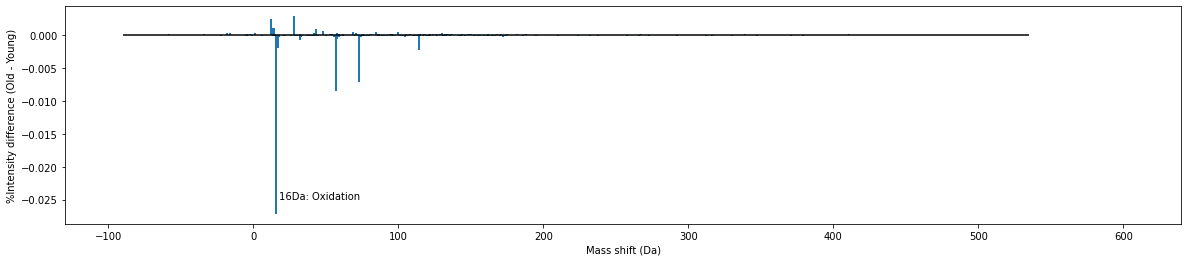

In [157]:
fig, ax = plt.subplots()
# ax = sns.barplot(data=gfiltered, x="Delta_mass", y="Quotient")
ax.bar(x=g.Delta_mass, height=g.Difference, width=1.4)
fig.set_size_inches(20,4)
plt.hlines(y=0,xmin=-90, xmax=535, color="k")
plt.text(x= 18, y= -0.025, s= "16Da: Oxidation")
plt.xlabel("Mass shift (Da)")
plt.ylabel("%Intensity difference (Old - Young)")
plt.show()

In [158]:
sorted = g.sort_values("Difference", axis=0, ascending=False)

In [159]:
sorted.head(10)

,Delta_mass,Unnamed: 0,Gene Names,Organism,Intensity_150828_PC_VUR_C1077,Intensity_150828_PC_VUR_C1133,Intensity_150828_PC_VUR_C1134,Intensity_150828_PC_VUR_C1138,Intensity_150828_PC_VUR_C1189,Intensity_150828_PC_VUR_C1205,...,Intensity_1DLC051815QE_RRAG_011B_rep1,Intensity_1DLC051815QE_RRAG_011B_rep2,Intensity_1DLC051815QE_RRAG_028B_rep1,Intensity_1DLC051815QE_RRAG_028B_rep2,Intensity_1DLC052815QE_RRAG_024B_rep1,Intensity_1DLC052815QE_RRAG_024B_rep2,Intensity_1DLC052815QE_RRAG_025B_rep1,MedianYoung,MedianOld,Difference
89,27.99,34016801,0.0,0.0,0.005851,0.004773,0.005013,0.004015,0.004019,0.004010,...,0.006246,0.006061,0.007911,0.007893,0.006525,0.008468,0.006648,0.004757,0.007654,0.002897
52,12.00,11439928,0.0,0.0,0.001944,0.001108,0.001691,0.000936,0.001023,0.001300,...,0.002588,0.002777,0.004560,0.004648,0.003648,0.003606,0.004530,0.001539,0.003959,0.002420
59,14.02,9030386,0.0,0.0,0.000804,0.000850,0.000664,0.000538,0.000951,0.000543,...,0.001266,0.002256,0.001887,0.002428,0.001345,0.001666,0.001724,0.000766,0.001829,0.001063
135,43.01,6496913,0.0,0.0,0.001043,0.001195,0.001270,0.000925,0.000864,0.000650,...,0.001462,0.001889,0.002161,0.001950,0.001724,0.001621,0.001976,0.000970,0.001992,0.001021
156,47.98,14243122,0.0,0.0,0.001099,0.000683,0.000552,0.000450,0.000616,0.000647,...,0.000112,0.000201,0.001356,0.000999,0.000341,0.000276,0.000980,0.000681,0.001395,0.000714
290,85.01,10012218,0.0,0.0,0.001515,0.001825,0.002224,0.001084,0.001859,0.001385,...,0.002827,0.002227,0.002230,0.002720,0.003073,0.003263,0.002272,0.001787,0.002272,0.000486
350,100.03,2434939,0.0,0.0,0.000308,0.000381,0.000500,0.000327,0.000405,0.000129,...,0.000672,0.000963,0.000784,0.000886,0.000366,0.000815,0.000919,0.000309,0.000778,0.000470
221,69.02,3443021,0.0,0.0,0.000348,0.000362,0.000526,0.000304,0.000349,0.000162,...,0.000445,0.000633,0.000935,0.000934,0.000854,0.001086,0.001109,0.000472,0.000934,0.000462
134,42.05,1759323,0.0,0.0,0.000000,0.000249,0.000195,0.000100,0.000107,0.000144,...,0.000640,0.000480,0.000556,0.000554,0.000707,0.000163,0.000660,0.000127,0.000493,0.000366
43,0.98,95881982,0.0,0.0,0.011432,0.013548,0.014057,0.014132,0.013617,0.013530,...,0.010073,0.011052,0.013740,0.014198,0.010904,0.010731,0.011644,0.013662,0.014027,0.000365


27.99: Formylation

12.00: Thiazolidine

14.02: methylation

43.01: Carbamyl!

47.98: Trioxidation

85.01: Carbamidomethyl + Formyl

100.03: Carbamidomethyl + Carbamyl

69.02: Carbamidomethyl + Thiazolidine

42.05: Trimethyl

0.98: Deamdiation

In [160]:
sorted.tail(10)

,Delta_mass,Unnamed: 0,Gene Names,Organism,Intensity_150828_PC_VUR_C1077,Intensity_150828_PC_VUR_C1133,Intensity_150828_PC_VUR_C1134,Intensity_150828_PC_VUR_C1138,Intensity_150828_PC_VUR_C1189,Intensity_150828_PC_VUR_C1205,...,Intensity_1DLC051815QE_RRAG_011B_rep1,Intensity_1DLC051815QE_RRAG_011B_rep2,Intensity_1DLC051815QE_RRAG_028B_rep1,Intensity_1DLC051815QE_RRAG_028B_rep2,Intensity_1DLC052815QE_RRAG_024B_rep1,Intensity_1DLC052815QE_RRAG_024B_rep2,Intensity_1DLC052815QE_RRAG_025B_rep1,MedianYoung,MedianOld,Difference
373,105.00,3302593,0.0,0.0,0.000203,0.000263,0.000337,0.000356,0.000310,0.000395,...,0.000000,0.000000,0.000357,0.000240,0.000130,0.000135,0.000124,0.000365,0.000130,-0.000235
245,73.99,2675604,0.0,0.0,0.000358,0.001343,0.001180,0.000613,0.000606,0.000662,...,0.000693,0.000154,0.000342,0.000522,0.000643,0.000211,0.000315,0.000783,0.000522,-0.000261
105,33.02,1368954,0.0,0.0,0.000000,0.000360,0.000288,0.000300,0.000298,0.000250,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000087,0.000285,0.000000,-0.000285
186,58.00,32840949,0.0,0.0,0.006729,0.007158,0.007245,0.006491,0.005957,0.006469,...,0.005696,0.006376,0.006659,0.005963,0.004945,0.004343,0.005592,0.007240,0.006659,-0.000581
102,31.98,15644714,0.0,0.0,0.003479,0.004071,0.004279,0.004283,0.004174,0.004294,...,0.001125,0.001033,0.001483,0.001448,0.001702,0.001609,0.001568,0.004205,0.003459,-0.000746
66,16.97,12732161,0.0,0.0,0.002274,0.003062,0.003273,0.002757,0.003134,0.002785,...,0.000419,0.000359,0.000723,0.000661,0.000989,0.001573,0.000641,0.003012,0.001144,-0.001868
406,114.04,52954826,0.0,0.0,0.018240,0.018474,0.019102,0.019611,0.018287,0.018363,...,0.016218,0.016315,0.017746,0.017928,0.016296,0.017484,0.018442,0.018748,0.016551,-0.002197
244,73.01,43180693,0.0,0.0,0.011169,0.013412,0.013862,0.013777,0.013440,0.013770,...,0.004420,0.004524,0.005639,0.005945,0.006602,0.006002,0.006583,0.013586,0.006435,-0.007151
185,57.02,179679405,0.0,0.0,0.142727,0.137354,0.143746,0.146627,0.139732,0.144688,...,0.139500,0.141002,0.140049,0.140192,0.136650,0.133416,0.143539,0.142500,0.134023,-0.008477
65,15.99,136372404,0.0,0.0,0.060650,0.066365,0.069202,0.072662,0.072604,0.073368,...,0.027365,0.026103,0.028840,0.024557,0.038797,0.036708,0.033780,0.069030,0.041848,-0.027183


15.99: Oxidation

57.02: Carbamidomethylation

73.01: Oxidation + carbamidomethylation

114.04: 2 carbamidomethylations

16.97: Oxidation + Deamidation

31.98: Dioxidation

58.00: Carbamidomethyl + Deamidation

33.02: Oxidation + Ammonium

73.99: Oxidation + Carbamidomethyl + Deamidation

105.00: Trioxidation + Carbamidomethyl